<a href="https://colab.research.google.com/github/joycerlz/distilbert-text-classification/blob/joyce-dev/distilbert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning DistilBERT for Multiclass Text Classification

## Import necessary libraries

In [ ]:
!pip  install transformers

In [ ]:
!pip install --upgrade tensorflow_hub

In [ ]:
!pip install tensorflow keras pickle

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TextClassificationPipeline
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf
import pandas as pd
import numpy as np
import json
import gc
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from plotly.offline import iplot

from tensorflow import keras
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import files

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

from tqdm import tqdm

In [5]:
df = pd.read_csv('augmented_df.csv')
df.head()

,text,labels
0,Am easily intimidated.,4
1,Get irritated easily.,4
2,Am always prepared.,4
3,Feel sympathy for those who are worse off than...,4
4,Get upset easily.,4


In [6]:
df.shape

(1665, 2)

# Split to train, validation, and test

In [7]:
data_texts = df['text'].to_list()
data_labels = df['labels'].to_list()

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.15, random_state=0)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.15, random_state=0)

In [9]:
print("Train set size:", len(train_texts))
print("Validation set size:", len(val_texts))
print("Test set size:", len(test_texts))

Train set size: 1202
Validation set size: 250
Test set size: 213


In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices( (dict(train_encodings), train_labels) )
val_dataset = tf.data.Dataset.from_tensor_slices( (dict(val_encodings), val_labels) )
test_dataset = tf.data.Dataset.from_tensor_slices( (dict(test_encodings), test_labels) )

train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)

# Fine tune with the model

**NOTE**

If encountered error "No module named 'keras.saving.hdf5_format'"

Steps to fix:

1. Expand this error traces (from the frames)
2. Go to the *transformers/modeling_tf_utils.py* file
3. Comment out the line (39) "```from keras.saving.hdf5_format import save_attributes_to_hdf5_group```"
4. Re-run

[Source](https://stackoverflow.com/questions/74586892/no-module-named-keras-saving-hdf5-format)

In [ ]:
# from transformers import TFDistilBertForSequenceClassification

In [12]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [13]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,optimizer=optimizer, metrics=['accuracy'], run_eagerly=True)

In [14]:
model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

Epoch 1/10
76/76 [==============================] - 407s 5s/step - loss: 1.5415 - accuracy: 0.3170 - val_loss: 1.3058 - val_accuracy: 0.5640
Epoch 2/10
76/76 [==============================] - 463s 6s/step - loss: 0.8698 - accuracy: 0.7354 - val_loss: 0.4587 - val_accuracy: 0.8520
Epoch 3/10
76/76 [==============================] - 411s 5s/step - loss: 0.2588 - accuracy: 0.9351 - val_loss: 0.1379 - val_accuracy: 0.9560
Epoch 4/10
76/76 [==============================] - 414s 5s/step - loss: 0.0789 - accuracy: 0.9867 - val_loss: 0.0817 - val_accuracy: 0.9760
Epoch 5/10
76/76 [==============================] - 406s 5s/step - loss: 0.0420 - accuracy: 0.9917 - val_loss: 0.1113 - val_accuracy: 0.9680
Epoch 6/10
76/76 [==============================] - 414s 5s/step - loss: 0.0242 - accuracy: 0.9967 - val_loss: 0.0697 - val_accuracy: 0.9760
Epoch 7/10
76/76 [==============================] - 413s 5s/step - loss: 0.0202 - accuracy: 0.9950 - val_loss: 0.0462 - val_accuracy: 0.9840
Epoch 8/10
76

## Evaluate

In [15]:
benchmarks = model.evaluate(test_dataset, return_dict=True, batch_size=16)
print(benchmarks)

14/14 [==============================] - 12s 827ms/step - loss: 0.0712 - accuracy: 0.9718
{'loss': 0.07117810845375061, 'accuracy': 0.9718309640884399}


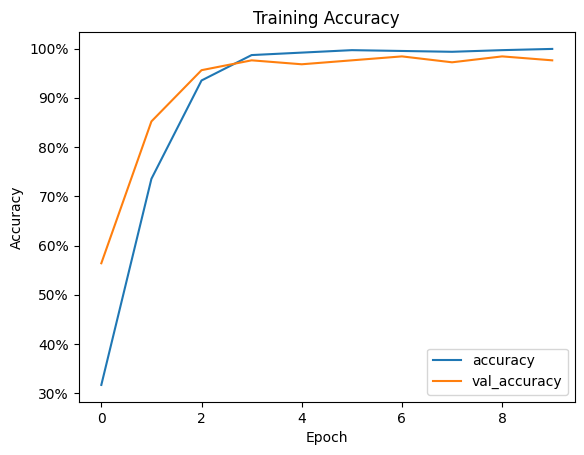

In [16]:
def plotAccuracy(model_history):
  plt.plot(model_history.history['accuracy'], label= 'accuracy')
  plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')
  plt.legend()

plotAccuracy(model_history)

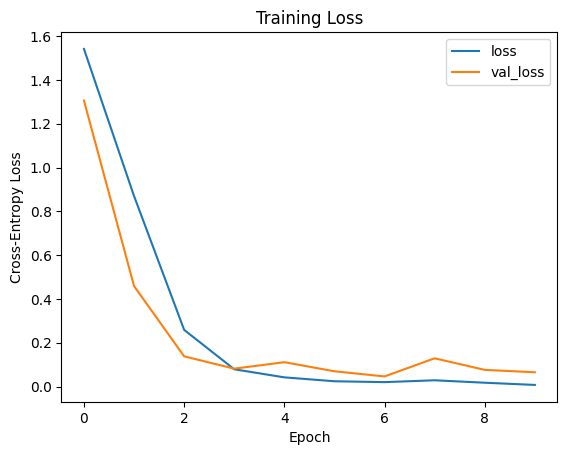

In [17]:
def plotLoss(model_history):
  plt.plot(model_history.history['loss'], label= 'loss')
  plt.plot(model_history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross-Entropy Loss')
  plt.title('Training Loss')
  plt.legend()

plotLoss(model_history)

In [18]:
tokenized_test = tokenizer(test_texts, padding=True, truncation=True, return_tensors="tf")
output = model.predict(tokenized_test)[0]
y_pred = np.argmax(output, axis=1)

print(classification_report(test_labels, y_pred))

7/7 [==============================] - 10s 1s/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        49
           1       1.00      1.00      1.00        48
           2       0.97      0.89      0.93        36
           3       0.98      0.98      0.98        41
           4       1.00      1.00      1.00        39

    accuracy                           0.97       213
   macro avg       0.97      0.97      0.97       213
weighted avg       0.97      0.97      0.97       213



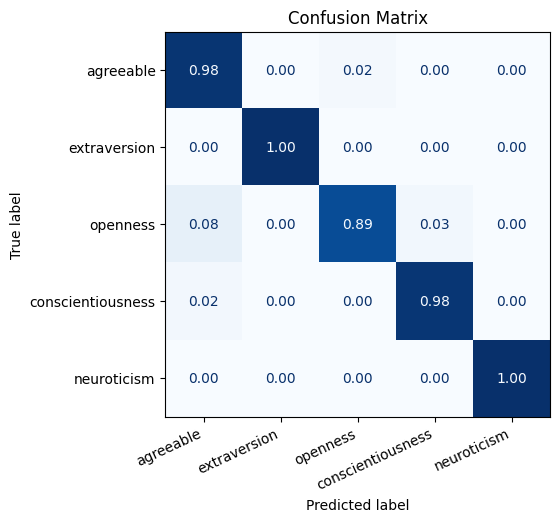

In [19]:
def plot_confusion_matrix(y_pred, y_true):
  labels = ["agreeable","extraversion","openness","conscientiousness","neuroticism"]
  cm = confusion_matrix(y_true, y_pred, normalize="true", labels=range(len(labels)))
  _, ax = plt.subplots(figsize=(5, 5))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion Matrix")
  ax.set_xticklabels(labels, rotation=25, ha="right")
  plt.show()

plot_confusion_matrix(y_pred, test_labels)

# Save the model

In [20]:
saved_model_path = "/distilbert-bigfive-v3"
os.makedirs(saved_model_path, exist_ok=True)
model.save_pretrained(saved_model_path)
tokenizer.save_pretrained(saved_model_path)

('/distilbert-bigfive-v3/tokenizer_config.json',
 '/distilbert-bigfive-v3/special_tokens_map.json',
 '/distilbert-bigfive-v3/vocab.txt',
 '/distilbert-bigfive-v3/added_tokens.json')

In [21]:
# Compress the directory containing the saved model and tokenizer
!zip -r distilbertv3.zip {saved_model_path}
files.download('distilbertv3.zip')

  adding: distilbert-bigfive-v3/ (stored 0%)
  adding: distilbert-bigfive-v3/vocab.txt (deflated 53%)
  adding: distilbert-bigfive-v3/config.json (deflated 50%)
  adding: distilbert-bigfive-v3/tokenizer_config.json (deflated 75%)
  adding: distilbert-bigfive-v3/tf_model.h5 (deflated 8%)
  adding: distilbert-bigfive-v3/special_tokens_map.json (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Loading Pre-Trained Model

In [22]:
!unzip distilbertv3.zip

Archive:  distilbertv3.zip
   creating: distilbert-bigfive-v3/
  inflating: distilbert-bigfive-v3/vocab.txt  
  inflating: distilbert-bigfive-v3/config.json  
  inflating: distilbert-bigfive-v3/tokenizer_config.json  
  inflating: distilbert-bigfive-v3/tf_model.h5  
  inflating: distilbert-bigfive-v3/special_tokens_map.json  


In [23]:
saved_model_path = "/distilbert-bigfive-v3"
tokenizer_v3 = DistilBertTokenizer.from_pretrained(saved_model_path)
model_v3 = TFDistilBertForSequenceClassification.from_pretrained(saved_model_path)

Some layers from the model checkpoint at /distilbert-bigfive-v3 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /distilbert-bigfive-v3 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# sample test
example = 'I loving drinking with friends on friday nights'

example_en = tokenizer_v3(example, truncation=True, padding=True, return_tensors='tf')
output = model_v3(example_en)[0]
pred = np.argmax(output, axis=1)
print(f'Predicted label: {pred}')

Predicted label: [1]


## Test with example conversation

In [ ]:
conversation = ["I’m tired all the time, no matter how much sleep I get.",
                "Sometimes I just want to disappear and not exist anymore.",
                "It’s hard to concentrate or focus on anything.",
                "I feel like I’m a burden to everyone around me.",
                "Everything feels pointless and meaningless.",
                "It’s like there’s a constant weight on my chest that won’t go away."]

In [ ]:
train_encodings = tokenizer(conversation, truncation=True, padding=True)